# CSE 152A Fall 2024 – Assignment 1


- Assignment Published On: **Thursday, Jan 18, 2024**

- Due On: **Mon, Jan 29, 2024 11:59 PM (Pacific Time)**

## Instructions

Please answer the questions below using Python in the attached Jupyter notebook and follow the guidelines below:
 
- This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy posted on lecture slides.

- All the solutions must be written in this Jupyter notebook.

- After finishing the assignment in the notebook, please export the notebook as a PDF and submit both the notebook and the PDF (i.e. the `.ipynb` and the `.pdf` files) on Gradescope. (Note: Please ensure that all images/plots are clear in the pdf).

- You may use basic algebra packages (e.g. `NumPy`, `SciPy`, etc) but you are not allowed to use open source codes that directly solve the problems. Feel free to ask the instructor and the teaching assistants if you are unsure about the packages to use.

- It is highly recommended that you begin working on this assignment early.

- Make sure that you read hints for questions (wherever given).

**Late Policy:** Assignments submitted late will receive a 25% grade reduction for each 12 hours late (that is, 50% per day).

## Problem 1: Photometric Stereo [20 pts]

The goal of this problem is to implement Lambertian photometric stereo. 

Note that the albedo is unknown and non-constant in the images you will use.

As input, your program should take in multiple images along with the light source direction for each image.

### Data
You will use synthetic images as data. These images are stored in `.pickle` files which were graciously provided by Satya Mallick. Each `.pickle` file contains

* `im1`, `im2`, `im3`, `im4`, ... images.
* `l1`, `l2`, `l3`, `l4`, ... light source directions.
  
You will find all the data for this part in `synthetic_data.pickle`.   
<br/>  
<b>Note:</b> Make sure to use `%matplotlib inline` to enable plotting by matplotlib in jupyter notebook/lab IDE

Keys: dict_keys(['__version__', 'l4', '__header__', 'im1', 'im3', 'im2', 'l2', 'im4', 'l1', '__globals__', 'l3'])
Image:


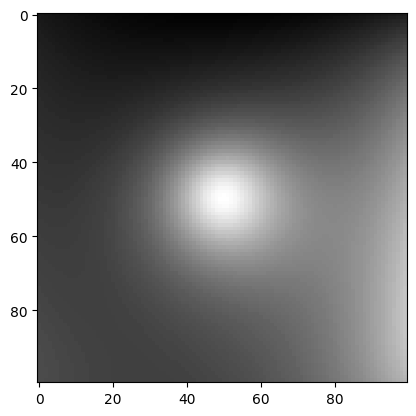

Light source direction: [[0 0 1]]


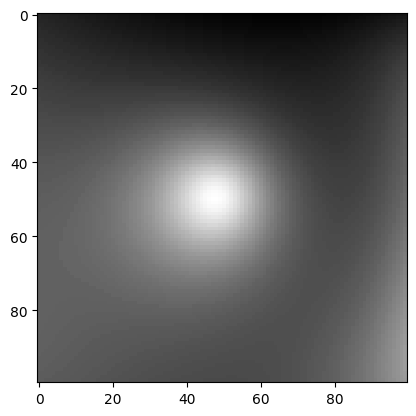

Light source direction: [[0.2 0.  1. ]]


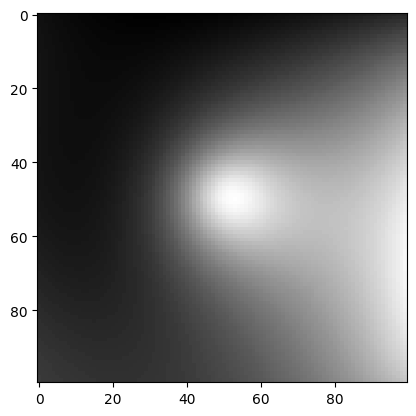

Light source direction: [[-0.2  0.   1. ]]


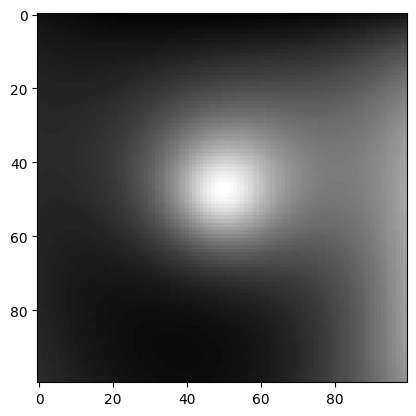

Light source direction: [[0.  0.2 1. ]]


In [1]:
## Example: How to read and access data from a pickle

import pickle
import matplotlib.pyplot as plt
%matplotlib inline
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

# data is a dict which stores each element as a key-value pair. 
print("Keys: " + str(data.keys()))

# To access the value of an entity, refer it by its key.
print("Image:")
plt.imshow(data["im1"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l1"]))

plt.imshow(data["im2"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l2"]))

plt.imshow(data["im3"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l3"]))

plt.imshow(data["im4"], cmap = "gray")
plt.show()

print("Light source direction: " + str(data["l4"]))

### 1(a) Photometric Stereo [8 pts]
  
Implement the photometric stereo technique described in the lecture. Your program should have two parts:
<ul>
<li>Read in the images and corresponding light source directions, and estimate the surface normals and albedo map. </li>
    <li>Reconstruct the depth map from the surface with the implementation of the Horn integration technique given below in `horn_integrate` function. Note that you will typically want to run the `horn_integrate` function with 10000 - 100000 iterations, meaning it will take a while.</li></ul>    
<br/>
$\textbf{Note:}$ The following `horn_integrate()` function is not to be edited for the purpose of solving this homework. Consider this to be a blackbox! 

In [2]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

# This function should be used as is for this homework. --> DO NOT EDIT!!!!!!!!!
def horn_integrate(gx, gy, mask, niter):
    """
    horn_integrate recovers the function g from its partial 
    derivatives gx and gy. 
    mask is a binary image which tells which pixels are 
    involved in integration. 
    niter is the number of iterations. 
    typically 100,000 or 200,000, 
    although the trend can be seen even after 1000 iterations.
    """
    g = np.ones(np.shape(gx))
    
    gx = np.multiply(gx, mask)
    gy = np.multiply(gy, mask)
    
    A = np.array([[0,1,0],[0,0,0],[0,0,0]]) #y-1
    B = np.array([[0,0,0],[1,0,0],[0,0,0]]) #x-1
    C = np.array([[0,0,0],[0,0,1],[0,0,0]]) #x+1
    D = np.array([[0,0,0],[0,0,0],[0,1,0]]) #y+1
    
    d_mask = A + B + C + D
    
    den = np.multiply(convolve(mask,d_mask,mode="same"),mask)
    den[den == 0] = 1
    rden = 1.0 / den
    mask2 = np.multiply(rden, mask)
    
    m_a = convolve(mask, A, mode="same")
    m_b = convolve(mask, B, mode="same")
    m_c = convolve(mask, C, mode="same")
    m_d = convolve(mask, D, mode="same")
    
    term_right = np.multiply(m_c, gx) + np.multiply(m_d, gy)
    t_a = -1.0 * convolve(gx, B, mode="same")
    t_b = -1.0 * convolve(gy, A, mode="same")
    term_right = term_right + t_a + t_b
    term_right = np.multiply(mask2, term_right)
    
    for k in range(niter):
        g = np.multiply(mask2, convolve(g, d_mask, mode="same")) + term_right
    
    return g

### !! Hint !! 

For computing partial derivatives, please note that this specific question assumes the following convention compared to the one presented in the class (that contains a negative sign). 

\begin{eqnarray}
\frac{\partial z}{\partial x} = \frac{\hat{n}_1}{\hat{n}_3} \\ 
\frac{\partial z}{\partial y} = \frac{\hat{n}_2}{\hat{n}_3}
\end{eqnarray}

Make sure to use the above convention to avoid painful debugging later on! Also, double check that the normals being used for plotting are unit normals. 

In [3]:
def photometric_stereo(images, lights, mask, horn_niter=25000):
    
    """mask is an optional parameter which you are encouraged to use.
    It can be used e.g. to ignore the background when integrating the normals.
    It should be created by converting the images to grayscale and thresholding
    (only using locations for which the pixel value is above some threshold).
    
    The choice of threshold is something you can experiment with,
    but in practice something like 0.05 tends to work well.
    """

    # note:
    # images : (n_ims, h, w)
    # lights : (n_ims, 3)
    # mask   : (h, w)
    
    albedo = np.ones(images[0].shape)
    normals = np.dstack((np.zeros(images[0].shape),
                         np.zeros(images[0].shape),
                         np.ones(images[0].shape)))

    H_horn = np.ones(images[0].shape)
    
    """ ==========
    YOUR CODE HERE           --> solve for albedo and get the normals
    ========== """
    
    ## --> albedo p is the diffuse color of an object (i.e. the color it would appear to have in a bright-evenly distributed light)
    ## I^k(x,y) = p(x,y)n(x,y) dot s^k  --> p(x,y)n(x,y) aka b(x,y)
    ## find the normals (as a unit vector) and find the albedo map to then estimate the surface
    ## put all images in a column vector I, all light sources in a matrix S, and b(x,y) as a column vector B
    ## then solve for B --> S may not be invertible so take pseudoinverse (S^T S)^-1
    ## then break about B into albedo and normals
    
    ## ## B = (S^T S)^-1 S^T I --> this is for one pixel (x,y) --> HAVE to do it for every pixel in the image
    ## the camera is static so the images dimensions are the same --> light intensity is different (i.e. the elements/pixels)
    h,w = images[0].shape # height, width of the images
    for i in range(h):
        for j in range(w):
            ## Create a stack of image light intensities at each pixel i,j (i.e. 3x1 column vector) to use to solve for b(i,j)
            img_pix = images[:,i,j]
            inv_lights = np.linalg.inv((np.dot(np.transpose(lights),lights))) # create the inverse of lights to solve for b(i,j)
            b = np.dot(inv_lights, np.dot(np.transpose(lights),img_pix)) # calculate b(i,j) for the specific pixel (i,j)
    
            mag_b = np.linalg.norm(b) # calculate the magnitude of b for the specific pixel (i,j)
    
            albedo[i,j] = mag_b # calculate albedo for the specific pixel i.e. || b(i,j) ||
            normals[i,j,:] = b[:] / mag_b  ## --> put each pixel's normal back in the normal matrix i.e. b(i,j) / || b(i,j) ||
    
    ## H_horn is the integration of the normals
    ## gx = del_z/ del_x = unit_n1/unit_n3 --> normals[0,0]/normals[0,2]
    ## gy = del_z/ del_y = unit_n2/unit_n3 --> normals[0,1]/normals[0,2]
    gx = normals[:,:,0]/normals[:,:,2]
    gy = normals[:,:,1]/normals[:,:,2]
    H_horn = horn_integrate(gx, gy, mask, horn_niter)
    
    return albedo, normals, H_horn

### 1(b) Display outputs using `im1`, `im2` and `im4` [6 Points]
  
<ul>
<li>The estimated albedo map.</li>

<li>The estimated surface normals by showing both
    <ul>
        <li>Needle map, and</li>
        <li>Three images showing the components of the surface normal.</li>
    </ul>
<li>A wireframe of the depth map.</li>
</ul>

An example of the outputs are shown below:

![Problem1%20example.png](Problem1%20example.png)

In [4]:
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------------------------
# The following code is just a working example so you don't get stuck with any
# of the graphs required. You may want to write your own code to align the
# results in a better layout. You are also free to change the function
# however you wish; just make sure you get all of the required outputs.
# --------------------------------------------------------------------------

def visualize(albedo, normals, horn_depth):
    # Stride in the plot, you may want to adjust it to different images
    stride = 15

    # showing albedo map
    fig = plt.figure()
    albedo_max = albedo.max()
    albedo = albedo / albedo_max
    plt.imshow(albedo, cmap="gray")
    plt.show()

    # showing normals as three separate channels
    figure = plt.figure()
    ax1 = figure.add_subplot(131)
    ax1.imshow(normals[..., 0])
    ax2 = figure.add_subplot(132)
    ax2.imshow(normals[..., 1])
    ax3 = figure.add_subplot(133)
    ax3.imshow(normals[..., 2])
    plt.show()

    # showing normals as quiver
    X, Y, _ = np.meshgrid(np.arange(0,np.shape(normals)[0], 15),
                          np.arange(0,np.shape(normals)[1], 15),
                          np.arange(1))
    X = X[..., 0]
    Y = Y[..., 0]
    Z = horn_depth[::stride,::stride].T
    NX = normals[..., 0][::stride,::-stride].T
    NY = normals[..., 1][::-stride,::stride].T
    NZ = normals[..., 2][::stride,::stride].T
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')
    plt.quiver(Y,X,Z,NX,NY,NZ, length=10)
    plt.show()

    # plotting wireframe depth map

    H = horn_depth[::stride,::stride]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X,Y, H.T)
    plt.show()

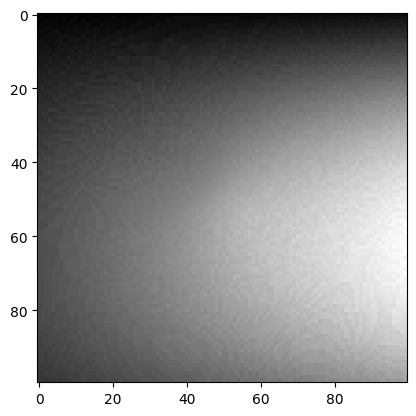

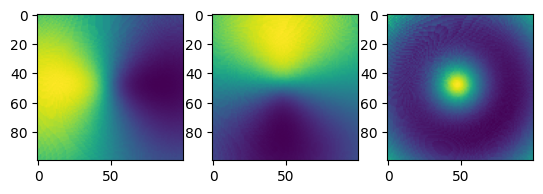

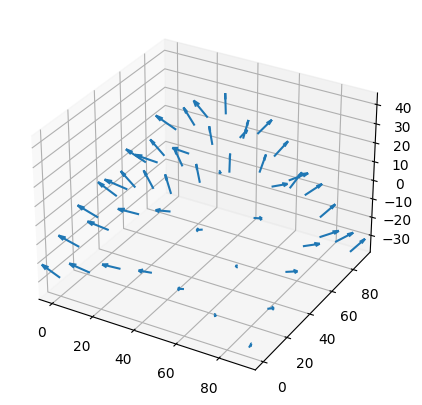

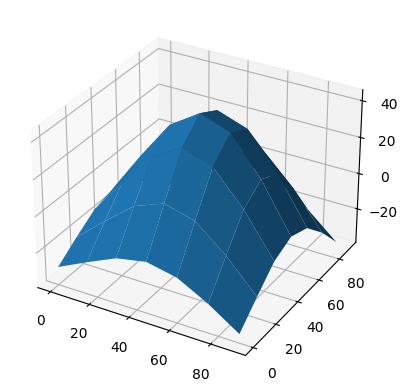

In [5]:
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, horn_depth = photometric_stereo(images, lights, mask)

visualize(albedo, normals, horn_depth)

### 1(c) Display outputs using all four images (most accurate result) [6 points]

<ul>
<li>The estimated albedo map.</li>

<li>The estimated surface normals by showing both
    <ul>
        <li>Needle map, and</li>
        <li>Three images showing components of surface normal.</li>
    </ul>
<li>A wireframe of depth map.</li>
</ul>
  
<b>Note:</b> Feel free to use the same mask as used in the previous part.

#### !! Hint !! 

You can refer to the code used in the cell above and adapt it to display the outputs for all the four images i.e im1, im2, im3 and im4 instead of just the 3 images i.e im1, im2 and im4 used before.

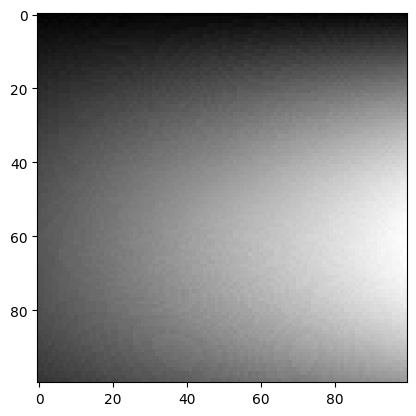

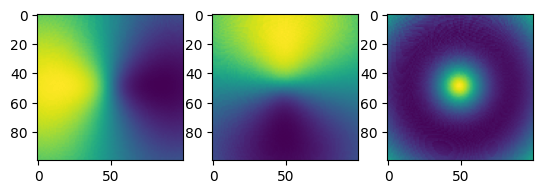

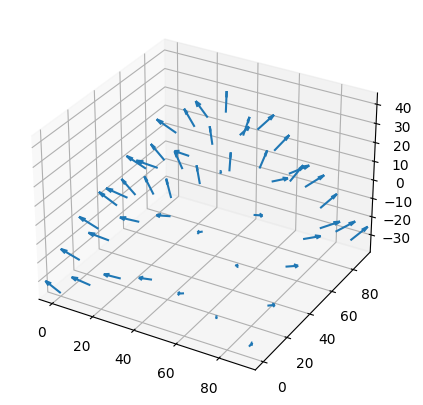

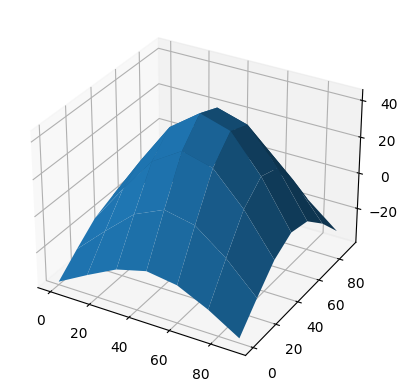

In [6]:
pickle_in = open("synthetic_data.pickle", "rb")
data = pickle.load(pickle_in, encoding="latin1")

lights = np.vstack((data["l1"], data["l2"], data["l3"], data["l4"]))

images = []
images.append(data["im1"])
images.append(data["im2"])
images.append(data["im3"])
images.append(data["im4"])
images = np.array(images)

mask = np.ones(data["im1"].shape)

albedo, normals, horn_depth = photometric_stereo(images, lights, mask)

visualize(albedo, normals, horn_depth)

## Problem 2: Image Rendering [20 points]


In this exercise, we will render the image of a face with two different point light sources using a Lambertian reflectance model. We will use two albedo maps, one uniform and one that is more realistic. The face heightmap, the light sources, and the two albedo are given in facedata.npy for Python (each row of the `lightsource` variable encode a light location). The data from facedata.npy is already provided to you.

<b>Note:</b> Please make good use out of subplot to display related image next to eachother.

### 2(a) Plot the face in 2-D [2 pts]

Plot both albedo maps using `imshow`. Explain what you observe in brief.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

# Load facedata.npy as ndarray
face_data = np.load('facedata.npy',encoding='latin1', allow_pickle=True)

# Load albedo matrix 
albedo = face_data.item().get('albedo')

# Load uniform albedo matrix
uniform_albedo = face_data.item().get('uniform_albedo')

# Load heightmap 
heightmap = face_data.item().get('heightmap')

# Load light source
light_source = face_data.item().get('lightsource')


### !! Hint !! 

Use the following link to learn about subplots: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

Make sure to use `cmap=gray` while showing the images in grayscale format otherwise you can expect to see green-yellow colors. 

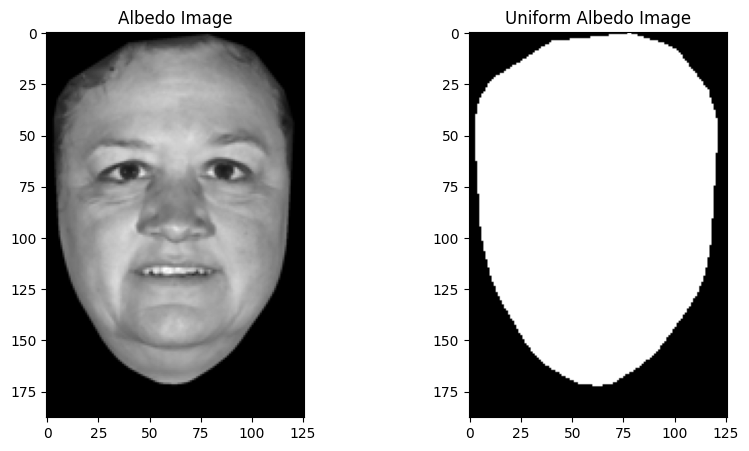

In [8]:
# Plot the face in 2-D (plot both albedo maps using imshow)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(albedo, cmap='gray')
axes[0].set_title('Albedo Image')

axes[1].imshow(uniform_albedo, cmap='gray')
axes[1].set_title('Uniform Albedo Image')

plt.show()

# Brief Observation
It seems that the albedo image itself displays the face of an individual in grayscale with their facial features present. The albedo image displays the reflectance properties as well as the contours around the bone structures. The uniform albedo displays just the black background with the face of the individual missing, replaced with an all white background. The uniform albedo (when albedo is 1) of the surface indicates that the surface's features such as material, contours, etc. all contributed to fully reflecting the incident light sources, producing an all white image.


### 2(b) Plot the face in 3-D [2 pts]

Using both the heightmap and the albedo, plot the face using plot\_surface. Do this for both albedos. Explain what you see.
<br/>
  
Learn about creating mesh grids here: https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html alternativly use https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

Learn about plotting surfaces here: https://matplotlib.org/2.2.5/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html?highlight=plot_surface#mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface

This example may help you to put things together: https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo.html


In [9]:
albedo.shape

(188, 126)

In [10]:
heightmap.shape

(188, 126)

### !! Hint !! 

Make sure to set strides to one, cmap should be gray, linewidth is zero and antialiased is set to false. Figure out how to use albedo via the parameter facecolors -- you may want to look up `plt.cm.gray()`!!

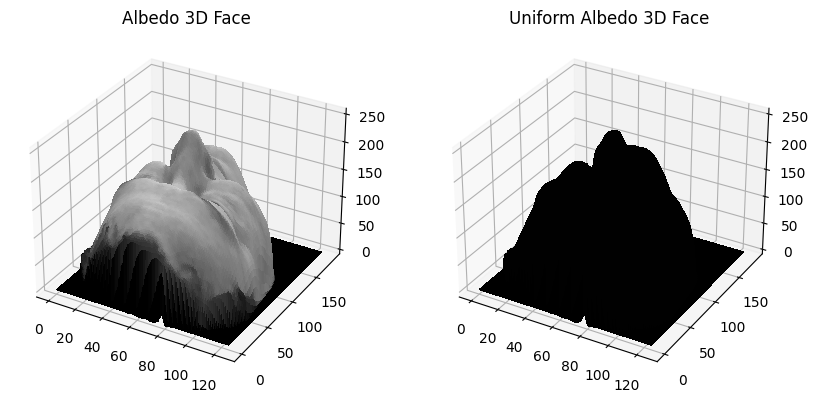

In [11]:
# Plot the face in 3-D 
# (Using the heightmap & albedo plot the faces using plot_surface)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Create the figure with two columns that will hold the two 3D faces
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})

# Albedo
X = np.arange(0,heightmap.shape[1],1) # Create the x axis
Y = np.arange(0,heightmap.shape[0],1) # Create the y axis
X, Y = np.meshgrid(X, Y) # Create the actual grid of the surface's base
Z = heightmap # Create the function that is to be plotted in 3D

# Plot the surface --> Z is the actual 2D function that we want to project to 3D space while X and Y are the dimenions of the grid
surf = axes[0].plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='gray', facecolors=plt.cm.gray(albedo), linewidth=0, antialiased=False) 

# Uniform Albedo
X2 = np.arange(0,heightmap.shape[1],1) # Create the x axis
Y2 = np.arange(0,heightmap.shape[0],1) # Create the y axis
X2, Y2 = np.meshgrid(X2, Y2) # Create the actual grid of the surface's base
Z2 = heightmap # Create the function that is to be plotted in 3D

# Plot the surface --> Z is the actual 2D function that we want to project to 3D space while X and Y are the dimenions of the grid
surf2 = axes[1].plot_surface(X2, Y2, Z2, rstride=1, cstride=1, cmap='gray', facecolors=plt.cm.gray(uniform_albedo), linewidth=0, antialiased=False) 

axes[0].set_title('Albedo 3D Face')
axes[1].set_title('Uniform Albedo 3D Face')
plt.show()

### 2(c) Surface normals [8 pts]

Calculate the surface normals and display them as a quiver plot using quiver in matplotlib.pyplot in Python. Recall that the surface normals are given by 
\begin{eqnarray}
[-\frac{\delta f}{\delta x}, -\frac{\delta f}{\delta y}, 1].
\end{eqnarray}
Also, recall, that each normal vector should be normalized to unit length.

### !! Hint !! 

You can use differencing to compute spatial derivatices (think about how to handle the boundaries?). You are also free to use convolutions (covered later in the class) which happens to be a much easier way of computing these derivatives. Learn about them here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html Which `mode` should you use?

For the quiver plots, read up https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html and make sure to use `length=10`. 

In [12]:
# Compute and plot the surface normals
# (make sure that the normal vector is normalized to unit length)
from scipy import signal

normals = np.stack((np.zeros(heightmap.shape),np.zeros(heightmap.shape),np.ones(heightmap.shape)), axis=-1)

# This part of the code should compute the normals i.e fill in the above normals variable correctly. Then just 
# execute the next cell to plot the surface normals

# Use convolution to calculate the spatial derivatives
Kx = 0.5 * np.array([[0,0,0],[1,0,-1],[0,0,0]])
Ky = 0.5 * np.array([[0,1,0],[0,0,0],[0,-1,0]])

# Use the surface function (i.e. heightmap) to find the spatial derivatives
df_dx = -1 * signal.convolve(heightmap,Kx,mode='same')
df_dy = -1 * signal.convolve(heightmap,Ky,mode='same')

# insert the spatial derivatives into the normals matrix
normals[:,:,0] = df_dx 
normals[:,:,1] = df_dy  # --> go through each normal and normalize

h,w,d = normals.shape

for i in range(h):
    for j in range(w):
        for k in range(d):
            normals[i,j,k] = normals[i,j,k]/np.linalg.norm(normals[i,j,:])

In [13]:
print("Max normal: ", np.max(normals))  # Normals matrix is guaranteed to be normalized
print("Min normal: ", np.min(normals))

Max normal:  1.0
Min normal:  -0.9998782292319791


In [14]:
# This code is used to visualise the surface normals plot. 
# Feel free to change the stride variable below. However DO NOT change the other parts of this code. 

stride = 10
X, Y = np.meshgrid(np.arange(0,np.shape(normals)[0], stride),
                          np.arange(0,np.shape(normals)[1], stride))

Z = heightmap[::stride,::stride].T
NX = -normals[...,0][::stride,::-stride].T
NY = -normals[...,1][::-stride,::stride].T
NZ = normals[...,2][::stride,::stride].T
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection = '3d')
plt.quiver(Y,X,Z,NX,NY,NZ, length=10)
plt.show()

### 2(d) Render images [8 pts]

For each of the two albedos, render three images. One for each of the two light sources, and one for both light-sources combined. Display these in a $2 \times 3$ subplot figure with titles. Recall that the general image formation equation is given by
\begin{eqnarray}
I = a(x,y) \hat{\boldsymbol{\mathrm{n}}}(x,y)^\top \hat{\boldsymbol{\mathrm{s}}}(x,y) s_0
\end{eqnarray}
where $a(x,y)$ is the albedo for pixel $(x, y)$, $\hat{n}(x,y)$ is the corresponding surface normal, $\hat{s}(x,y)$ the light source direction, $s_0$ the light source intensity. Let the light source intensity be $1$ and make the `distant light source assumption'.
Use imshow with appropriate keyword arguments .

### !! Hint !! 

Make sure that the images computed by `lambertian()` are non-negative. Otherwise you will see gray image background (which should be black). 

In [15]:
albedo.shape

(188, 126)

In [16]:
normals.shape

(188, 126, 3)

In [17]:
light_source.shape

(2, 3)

In [18]:
light_source.shape[0]

2

In [19]:
light_source[0]

array([120, 180, 300], dtype=uint16)

In [20]:
light_source[1]

array([ 20,  20, 300], dtype=uint16)

In [21]:
np.transpose(normals[0,0,:])

array([-1.11022302e-15, -1.24344979e-14,  1.00000000e+00])

In [22]:
np.min(normals)

-0.9998782292319791

In [23]:
# Render Images

def lambertian(normals, light, albedo, intensity, mask):
    # Ensure that light is a matrix of light sources with their respective directions
    h,w = albedo.shape
    I = np.zeros((light.shape[0],h,w))
    for i in range(light.shape[0]):
        for j in range(h):
            for k in range(w):
                I[i,j,k] = np.clip(albedo[j,k] * np.dot(np.transpose(normals[j,k,:]),light[i,:]/np.linalg.norm(light[i,:]))*intensity,0,1)
    return I
    pass

### !! Hint !! 
When combining the two light sources, notice the linearity of the image formation equation and make sure that image values lie between 0 and 1. 

In [24]:
# For each of the two albedos, render three images. 
# One for each of the two light sources, and one for both light-sources combined.
Images_albedo = lambertian(normals,light_source,albedo,1,1)
Images_uniform_albedo = lambertian(normals,light_source,uniform_albedo,1,1)

In [25]:
Images_albedo.shape

(2, 188, 126)

In [26]:
np.max(Images_albedo[0])

1.0

In [27]:
np.min(Images_albedo[0])

0.0

In [28]:
uniform_albedo.max()

1

In [29]:
uniform_albedo.min()

0

In [30]:
# Plot the 6 faces (3 for each albedo map)
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

axes[0,0].imshow(Images_albedo[0], cmap='gray')
axes[0,0].set_title('Albedo LS1')

axes[0,1].imshow(Images_albedo[1], cmap='gray')
axes[0,1].set_title('Albedo LS2')

axes[0,2].imshow(Images_albedo[0]+Images_albedo[1], cmap='gray')
axes[0,2].set_title('Albedo LS1 + Albedo LS2')

axes[1,0].imshow(Images_uniform_albedo[0], cmap='gray')
axes[1,0].set_title('Unfiorm Albedo LS1')

axes[1,1].imshow(Images_uniform_albedo[1], cmap='gray')
axes[1,1].set_title('Uniform Albedo LS2')

axes[1,2].imshow(Images_uniform_albedo[0]+Images_uniform_albedo[1], cmap='gray')
axes[1,2].set_title('Uniform Albedo LS1 + Uniform Albedo LS2')

plt.show()

## Problem 3: Homogeneous Coordinates and Vanishing Points [20 points]
  
In class, we discussed the concept of homogeneous coordinates. In this example, we will confine ourselves to the real 2D plane. A point $(x, y)^\top$ on the real 2D plane can be represented in homogeneous coordinates by a 3-vector $(wx, wy, w)^\top$, where $w \neq 0$ is any real number. All values of $w \neq 0$ represent the same 2D point. Dividing out the third coordinate of a  homogeneous point $(x, y, z)$ converts it back to its 2D equivalent: $\left( \displaystyle\frac{x}{z}, \displaystyle\frac{y}{z} \right)^\top$.

Consider a line in the 2D plane, whose equation is given by $ax + by + c = 0$. This can equivalently be written as $\textbf{l}^\top \textbf{x} = 0$, where $\textbf{l} = (a, b, c)^\top$ and $\textbf{x} = (x, y, 1)^\top$. Noticing that $\textbf{x}$ is a homogeneous representation of $(x, y)^\top$, we define $\textbf{l}$ as a homogeneous representation of the line $ax + by + c = 0$. Note that the line $(ka)x + (kb)y + (kc) = 0$ for $k \neq 0$ is the same as the line $ax + by + c = 0$, so the homogeneous representation of the line $ax + by + c = 0$ can be equivalently given by $(a, b, c)^\top$ or $(ka, kb, kc)^\top$ for any $k \neq 0$.

All points $(x, y)$ that lie on the line $ax + by + c = 0$ satisfy the equation $\textbf{l}^\top \textbf{x} = 0$, thus, we can say that a condition for a homogeneous point $\textbf{x}$ to lie on the homogeneous line $\textbf{l}$ is that their dot product is zero, that is, $\textbf{l}^\top \textbf{x} = 0$. We note this down as a fact:
  
<b>Fact 1:</b> A point $\textbf{x}$ in homogeneous coordinates lies on the homogeneous line $\textbf{l}$ if and only if
$$
\textbf{x}^\top \textbf{l} = \textbf{l}^\top \textbf{x} = 0
$$

<!--   <div style="text-align: right"><b>[1 Point]</b></div> -->
Now let us solve a few simple examples:

<ul>
    <li><b>3(a)</b> Give at least two homogeneous representations for the point $(4, 5)^\top$ on the 2D plane, one with $w > 0$ and one with $w < 0$. <div style="text-align: right"><b>[1 Point]</b></div></li>
    

In [1]:
import numpy as np
from scipy.signal import convolve
from numpy import linalg

For w > 0: $(4, 5, 1)^\top$

For w < 0: $(-4, -5, -1)^\top$

<ul>
<li><b>3(b)</b> What is the equation of the line passing through the points $(1, 1)^\top$ and $(-1, 2)^\top$ [in the usual Cartesian coordinates]? Now write down a 3-vector that is a homogeneous representation for this line. <div style="text-align: right"><b>[2 Points]</b></div></li>
</ul>


Cartesian coordinates: 

Point 1: $(1,1)$
Point 2: $(-1,2)$

$m = \frac{2 - 1}{-1 - 1} = \frac{-1}{2}$ 

After finding the slope, we can use the slope-intercept form equation to find the line that crosses both of the points by substituing either point into the equation.

$1 = \frac{-1}{2}(1) + b \rightarrow b = \frac{3}{2} \rightarrow y = -\frac{1}{2}x+\frac{3}{2} \rightarrow \frac{1}{2}x+y-\frac{3}{2} = 0 \rightarrow (\frac{1}{2}, 1, -\frac{3}{2})^\top$

Using a scalar multiple of $-2$, that is multiplying the whole equation by $-2$, we can then represent the line vector as $(-2\times-\frac{1}{2}, -2\times1, -2\times-\frac{3}{2})^\top = (-1, -2, 3)^\top$

Homogenous representation: $(-1, -2, 3)^\top$

In [2]:
H_1 = np.array([1,1,1])
H_2 = np.array([-1,2,1])
homo_line = np.cross(H_1,H_2)
print("Homogenous line crossing these two points: ", homo_line, "^T")

Homogenous line crossing these two points:  [-1 -2  3] ^T


We will now move on to consider the intersection of two lines. We make the claim that: "The (homogeneous) point of intersection, $\textbf{x}$, of two homogeneous lines $\textbf{l}_1$ and $\textbf{l}_2$ is
$\textbf{x} = \textbf{l}_1 \times \textbf{l}_2$, where $\times$ stands for the vector (or cross) product". 

<ul>
    <li><b>3(c)</b> In plain English, how will you express the condition a point must satisfy to lie at the intersection of two lines? Armed with this simple condition, and using <b>Fact 1</b>, can you briefly explain why $\textbf{l}_1 \times \textbf{l}_2$ must lie at the intersection of lines $\textbf{l}_1$ and $\textbf{l}_2$? <div style="text-align: right"><b>[5 Points]</b></div></li>
</ul>

In [3]:
result1 = np.dot(homo_line,H_1)
result2 = np.dot(homo_line,H_2)
print("Result 1: ", result1)
print("Result 2: ", result2)

Result 1:  0
Result 2:  0


Homogenous line 1 ($\textbf{l}_1$) and homogenous line 2 ($\textbf{l}_2$) are in vector form. By definition, the cross products of two vectors create a new vector that is orthogonal to both vectors (i.e. our homogenous lines). This homogenous vector can also be thought of as a point that lies at the intersection of these two homogenous lines. The two homogenous lines must also intersect themselves. As a result, in order for this homogenous point to lie at the intersection of two homogenous lines, the dot product between this point and each line must be equal to 0. This indicates that the vector that represents this point must form an angle of 90 degrees with each of the two homogenous line vectors, $\textbf{l}_1$ and $\textbf{l}_2$. In other words, the homogenous point must lie on both $\textbf{l}_1$ and $\textbf{l}_2$ and for that to be possible, the homogenous point must be at the intersection of these two homogenous lines.

In the following, we will use the above stated claim for the intersection of two lines.
  
<ul>
    <li><b>3(d)</b> Consider the two lines $x + y + 5 = 0$ and $3x - 5y + 7 = 0$. Use the claim in question <b>3(c)</b> to find their intersection in homogeneous coordinates. Next, convert this homogeneous point back to standard Cartesian coordinates and report the 2D point of intersection. <div style="text-align: right"><b>[3 Points]</b></div></li>
</ul>

In [4]:
H_1 = np.array([1,1,5])
H_2 = np.array([3,-5,7])
homo_coord = np.cross(H_1,H_2)
print("Homogenous coordinates of intersection: ", homo_coord, "^T")

cart_coord = homo_coord[:-1]/homo_coord[-1]
print("Cartesian coordinates (2D point of intersection): ", cart_coord, "^T")

Homogenous coordinates of intersection:  [32  8 -8] ^T
Cartesian coordinates (2D point of intersection):  [-4. -1.] ^T


Cartesian Coordinates: $(-4, -1)^\top$

Homogenous Coordinates: $(32, 8, -8)^\top$

 <ul><li><b>3(e)</b> Consider the two lines $x + 2y + 1 = 0$ and $2x + 4y - 2 = 0$. What is the special relationship between these two lines in the Euclidean plane? What is their intersection in standard Cartesian coordinates? <div style="text-align: right"><b>[2 Points]</b></div></li></ul>

The special relationship of the above lines is that they are parallel. In other words, they do not have a formal intersection in Cartesian coordinates.

<ul><li><b>3(f) </b> Write the homogeneous representations of the above two lines from part <b>3(e)</b> and compute their point of intersection in homogeneous coordinates. What is this point of intersection called in computer vision parlance?  <div style="text-align: right"><b>[3 Points]</b></div></li></ul>
   

In [5]:
H_1 = np.array([1,2,1])
H_2 = np.array([2,4,-2])
homo_coord = np.cross(H_1,H_2)
print("Homogenous coordinates of intersection: ", homo_coord, "^T")

Homogenous coordinates of intersection:  [-8  4  0] ^T


The two homogenous lines, $(1, 2, 1)^\top$ and $(2, 4, -2)^\top$ form a homogenous intersection at $(-8,4,0)^\top$ which means that in 3D space, the two real lines are parallel and never intersect. This point of intersection is called an ideal point in computer vision.

<ul><li><b>3(g)</b> Do questions <b>3(e)</b> and <b>3(f)</b> justify the claim in class, that homogeneous coordinates provide a uniform treatment of line intersection, regardless of parallelism? Briefly explain.<div style="text-align: right"><b>[2 Points]</b></div></li></ul>
  

The two questions above do justify the claim in class. This is because although there is no actual point of intersection between two parallel lines in 3D space (i.e. the real world), when they are projected to 2D space (i.e. an image) in homogenous coordinates, these parallel lines in the real world are obstructed in the projection such that they seem to intersect regardless of this being the contrary. When converting this ideal point back to non-homogenous 2D coordinates, the division by $0$ (i.e. the last element in the homogenous vector) will cause an issue producting infinity for the $x$ and $y$ points of the coordinate which explains the parallelism in the real world of two parallel lines.

<ul><li><b>3(h)</b> Give (with justification) an expression for the homogeneous representation of the line passing through two homogeneous points $\textbf{x}_1$ and $\textbf{x}_2$. [<em>Hint:</em> Construct an argument analogous to the one for the intersection of two lines in part <b>3(c)</b>.] <div style="text-align: right"><b>[2 Points]</b></div></li></ul>
    

The homogenous line, $\textbf{l}$, passing through the homogenous points $\textbf{x}_1$ and $\textbf{x}_2$ is given by the cross product: $\textbf{l} = \textbf{x}_1 \times \textbf{x}_2$. By duality this is true because we can represent homogenous points as vectors with 3 entries. If we take the cross product of two homogenous points represented as vectors, we will result in a homogenous vector that is orthogonal to both vectors $\textbf{x}_1$ and $\textbf{x}_2$. If the resultant vector is orthogonal to both these vectors, that implies that it forms a 90 degree angle with each vector, where the start of the homogenous vector is at the point $\textbf{x}_1$ AND at the point $\textbf{x}_2$. The only way for the resultant homogenous vector to be orthoganl to both of these vectors is if if passes through both the vectors (i.e. both points). In addition, if we take the dot product of $\textbf{l}$ and $\textbf{x}_1$, and the dot product of $\textbf{l}$ and $\textbf{x}_2$, both will result in 0, meaning that both points are on this same homgenous line which is represented as the result vector of the cross product between $\textbf{x}_1 \times \textbf{x}_2$.

# Problem 4: Camera Matrices and Rigid-Body Transformations [20 points]
  
Consider a world coordinate system $W$, centered at the origin $(0, 0, 0)$, with axes given by unit vectors $\widehat{\textbf{i}} = (1, 0, 0)^\top$, $\; \widehat{\textbf{j}} = (0,1,0)^\top$ and $\widehat{\textbf{k}} = (0,0,1)^\top$. We use a notation where boldfaces stand for a vector and a hat above a boldface letter stands for a unit vector.
  
<ul>
    <li><b>4(a)</b> Consider another coordinate system, with unit vectors along two of the orthogonal axes as:<br> $\widehat{\textbf{i}}' =  (0.688, −0.688, 0.229)^\top$ and $\widehat{\textbf{j}}' = (0.267, 0.534, 0.801)^\top$. Find the unit vector, $\widehat{\textbf{k}}'$, along the third axis orthogonal to both $\widehat{\textbf{i}}'$ and $\widehat{\textbf{j}}'$. Is there a unique such unit vector? If not, choose the one that makes an acute angle with $\widehat{\textbf{k}}$.<div style="text-align: right"><b>[2 Points]</b></div></li>
</ul>
    

In [6]:
i_hat_prime = np.array([0.688,-0.688,0.229])
j_hat_prime = np.array([0.267,0.534,0.801])
k_hat_prime = np.cross(i_hat_prime,j_hat_prime)
k_hat_prime

array([-0.673374, -0.489945,  0.551088])

The third axis, $\widehat{\textbf{k}}'$, that is orthogonal to both $\widehat{\textbf{i}}'$ and $\widehat{\textbf{j}}'$, is given by $(-0.673374, -0.489945, 0.551088)^\top$.

<ul><li><b>4(b)</b> Find the rotation matrix that rotates any vector in the $(\widehat{\textbf{i}}, \widehat{\textbf{j}}, \widehat{\textbf{k}})$ coordinate system to the $(\widehat{\textbf{i}}', \widehat{\textbf{j}}', \widehat{\textbf{k}}')$ coordinate system.<div style="text-align: right"><b>[2 Points]</b></div></li></ul>
    
#### !! Hint !!

The rotation matrix is given by R =

$$
\begin{bmatrix}
    u^T \\
    v^T \\
    w^T \\
\end{bmatrix}
$$

In [7]:
i_hat = np.array([1,0,0])
j_hat = np.array([0,1,0])
k_hat = np.array([0,0,1])

old_cs = np.array([i_hat,j_hat,k_hat])
new_cs = np.array([i_hat_prime,j_hat_prime,k_hat_prime])
rotation_matrix = np.dot(np.linalg.inv(old_cs),new_cs)
rotation_matrix

array([[ 0.688   , -0.688   ,  0.229   ],
       [ 0.267   ,  0.534   ,  0.801   ],
       [-0.673374, -0.489945,  0.551088]])

The rotation matrix for the above is $R = \begin{bmatrix}
  0.688 & -0.688 & 0.229\\
  0.267 & 0.534 & 0.801\\
  -0.673374 & -0.489945 & 0.551088\\
\end{bmatrix}$

<ul><li><b>4(c)</b> What is the <em>extrinsic parameter matrix</em> for a camera at a displacement $(-1, -2, -5)^\top$ from the origin of $W$ and oriented such that its principal axis coincides with $\widehat{\textbf{k}}'$, the x-axis of its image plane coincides with $\widehat{\textbf{i}}'$ and the y-axis of the image plane coincides with $\widehat{\textbf{j}}'$? <div style="text-align: right"><b>[3 Points]</b></div></li></ul>

#### !! Hint !!
The extrinsic parameter matrix is given by: 

$$
\left(\begin{array}{cc} 
R & -RC\\
0^{T} & 1
\end{array}\right)
$$

where R is the rotation matrix and C is the camera center.
    

In [8]:
C = np.array([[-1],[-2],[-5]])

In [9]:
C

array([[-1],
       [-2],
       [-5]])

In [10]:
C.shape

(3, 1)

In [11]:
rotation_matrix.shape

(3, 3)

In [12]:
RC_neg = np.vstack((-1 * np.matmul(rotation_matrix,C),1))
RC_neg

array([[0.457   ],
       [5.34    ],
       [1.102176],
       [1.      ]])

In [13]:
rotation_matrix = np.vstack((rotation_matrix,np.zeros(rotation_matrix[0].shape)))
rotation_matrix

array([[ 0.688   , -0.688   ,  0.229   ],
       [ 0.267   ,  0.534   ,  0.801   ],
       [-0.673374, -0.489945,  0.551088],
       [ 0.      ,  0.      ,  0.      ]])

In [14]:
extrinsic_param = np.hstack((rotation_matrix,RC_neg))

In [15]:
extrinsic_param

array([[ 0.688   , -0.688   ,  0.229   ,  0.457   ],
       [ 0.267   ,  0.534   ,  0.801   ,  5.34    ],
       [-0.673374, -0.489945,  0.551088,  1.102176],
       [ 0.      ,  0.      ,  0.      ,  1.      ]])

The extrinsic parameter is $\begin{bmatrix}
  0.688 & -0.688 & 0.229 & 0.457\\
  0.267 & 0.534 & 0.801 & 5.34\\
  -0.673374 & -0.489945 & 0.551088 & 1.102176\\
  0 & 0 & 0 & 1\\
\end{bmatrix}$

<ul><li><b>4(d)</b> What is the <em>intrinsic parameter matrix</em> for this camera, if its focal length in the x-direction is $1024$ pixels, aspect ratio is $1$, pixels deviate from rectangular by $0$ degrees and principal point is offset from the center $(0, 0)^\top$ of the image plane to the location $(10, -5)^\top$?<div style="text-align: right"><b>[3 Points]</b></div></li></ul>
    

In [16]:
# 1024 pixels in x-direction --> px = 1024
# a = 1 = dx'/dy' = dpx/dpy --> py = 1024
# principal point (c_x,c_y) = (10,-5)
# skew = 0
intrinsic_param = np.array([[-1024,0,10],[0,-1024,-5],[0,0,1]])
intrinsic_param

array([[-1024,     0,    10],
       [    0, -1024,    -5],
       [    0,     0,     1]])

<ul><li><b>4(e)</b> Write down the projection matrix for the camera described by the configuration in parts <b>4(c)</b> and <b>4(d)</b>. <div style="text-align: right"><b>[3 Points]</b></div></li></ul>

#### !! Hint !!

The projection matrix is given by P = K [ R | −RC ] where K in the intrinsic matrix, R is the rotation matrix and C is the camera center. 
    

In [17]:
projection_identity = np.hstack((np.identity(3),np.array([[0],[0],[0]])))
projection_identity

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [18]:
# Implementation 1 --> including the identity matrix with a column of zeroes stacked horizontally to create the projection matrix
intrinsic_param_proj = np.matmul(intrinsic_param,projection_identity)
projection_mat = np.matmul(intrinsic_param_proj,extrinsic_param)
projection_mat

array([[-7.11245740e+02,  6.99612550e+02, -2.28985120e+02,
        -4.56946240e+02],
       [-2.70041130e+02, -5.44366275e+02, -8.22979440e+02,
        -5.47367088e+03],
       [-6.73374000e-01, -4.89945000e-01,  5.51088000e-01,
         1.10217600e+00]])

In [19]:
intrinsic_param.shape

(3, 3)

In [20]:
np.hstack((rotation_matrix[:-1, :],RC_neg[:-1, :]))

array([[ 0.688   , -0.688   ,  0.229   ,  0.457   ],
       [ 0.267   ,  0.534   ,  0.801   ,  5.34    ],
       [-0.673374, -0.489945,  0.551088,  1.102176]])

In [21]:
# Implementation 2 --> not adding any of the rows or columns
proj = np.matmul(intrinsic_param,np.hstack((rotation_matrix[:-1, :],RC_neg[:-1, :])))
proj

array([[-7.11245740e+02,  6.99612550e+02, -2.28985120e+02,
        -4.56946240e+02],
       [-2.70041130e+02, -5.44366275e+02, -8.22979440e+02,
        -5.47367088e+03],
       [-6.73374000e-01, -4.89945000e-01,  5.51088000e-01,
         1.10217600e+00]])

The projection matrix is $\begin{bmatrix}
  -7.11245740e+02 & 6.99612550e+02 & -2.28985120e+02 & -4.56946240e+02\\
  -2.70041130e+02 & -5.44366275e+02 & -8.22979440e+02 & -5.47367088e+03\\
  -6.73374000e-01 & -4.89945000e-01 & 5.51088000e-01 & 1.10217600e+00\\
\end{bmatrix}$

<ul><li><b>4(f)</b> Consider a plane, orthogonal to $\widehat{\textbf{k}}$, at a displacement of $2$ units from the origin of $W$ along the $\widehat{\textbf{k}}$ direction. Consider a disk with radius $1$, centered at $(0, 0, 2)^\top$ in the coordinate system $W$. We wish to find the image of this disk, as seen by the camera we constructed in part <b>4(e)</b>. The following questions need programming (use Python) and the code for each part should be turned in along with any figures and answers to specific questions. Explain your variable names (with comments). Feel free to supply any additional description or explanation to go with your code.
    
</li></ul>

<ul><ol>
            <li> Compute 10000 well-distributed points on the surface of unit disk. One way to do this is to sample the angular range $0$ to $360$ degrees into 10000 equal parts and convert the resulting points from polar coordinates (radius is $1$) to Cartesian coordinates. Display the disk, make sure that the axes of the display figure are equal.<div style="text-align: right"><b>[2 Points]</b></div></li>
</ol></ul>

### !! Hint !! 
The following code snippet generates one such random point: 
    
    r = R * sqrt(random()) 
    theta = random() * 2 * PI`

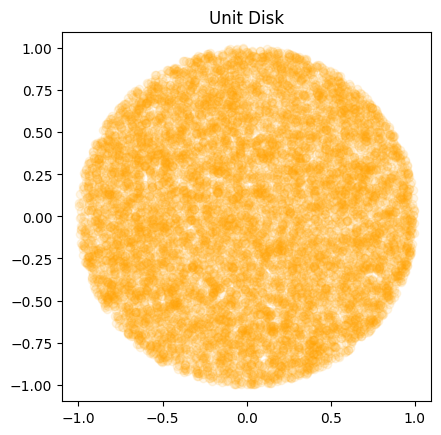

In [74]:
import matplotlib.pyplot as plt
import numpy as np
# Number of points
num_points = 10000
# Distribute the points on the unit circle
r_values = np.sqrt(np.random.random(num_points))
theta_values = 2 * np.pi * np.random.random(num_points)
# Convert polar coordinates to Cartesian coordinates
x_values = r_values * np.cos(theta_values)
y_values = r_values * np.sin(theta_values)
# Plot the points on the unit disk
plt.scatter(x_values, y_values, color='orange', alpha=0.1)
# Set the x and y axes scales to be equal (i.e. same aspect ratio) 
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Unit Disk')
plt.show()

<ul><ol start="2">
<li> Add the $z$ coordinate to these points, which is $2$ for all of them. Make all the points homogeneous by adding a fourth coordinate equal to $1$. <div style="text-align: right"><b>[1 Point]</b></div></li>
</ol></ul>        

In [55]:
y_values

array([ 0.64656886, -0.64858483, -0.2044972 , ...,  0.3846931 ,
       -0.63621364,  0.44992222])

In [56]:
x_values

array([ 0.32811604,  0.25880763, -0.40538008, ...,  0.18606102,
       -0.72375049,  0.10650578])

In [57]:
# add a third and fourth coordinate to each point --> make a 3D homogenous vector (x,y,2,1)
# reshape the x_values to stack horizontally
x_s = np.reshape(x_values, (10000, 1))
# reshape the y_valyes to stack horizontally
y_s = np.reshape(y_values, (10000,1))
# create the column vector of all twos to horizontally stack to the x,y pairs
z_s = np.full((10000, 1), 2)
# create the column vector of ones to horizontally stack to the x,y,z pairs to convert to homogenous
ones = np.ones((10000,1))
# 10000 x 4 matrix that holds the (x,y,z,1) value pairs --> stack all the column vectors together
homo_coords = np.hstack((x_s,y_s,z_s,ones))

In [58]:
homo_coords

array([[ 0.32811604,  0.64656886,  2.        ,  1.        ],
       [ 0.25880763, -0.64858483,  2.        ,  1.        ],
       [-0.40538008, -0.2044972 ,  2.        ,  1.        ],
       ...,
       [ 0.18606102,  0.3846931 ,  2.        ,  1.        ],
       [-0.72375049, -0.63621364,  2.        ,  1.        ],
       [ 0.10650578,  0.44992222,  2.        ,  1.        ]])

<ul><ol start="3">
<li> Compute the projection of these homogeneous points using the camera matrix from part <b>4(e)</b>. Convert the homogeneous projected points to 2D Cartesian points by dividing out (and subsequently discarding) the third coordinate of each point.<div style="text-align: right"><b>[2 Points]</b></div></li>
</ol></ul>        

In [70]:
# Project into 2D space using the projection matrix
# Iterate through each row of the homo_coords matrix holding the (x,y,z,1) pairs of the 3D disk
# Tranpose/reshape each row when iterating to create a column vector and multiply by the projection matrix found in part 4e
h = homo_coords.shape[0]
# Matrix holding the 10000 projected points
projected_points = np.zeros((h, 2))
for i in range(h):
    point = np.reshape(homo_coords[i,:], (len(homo_coords[i,:]),1))
    result = np.matmul(proj,point)
    result = np.reshape(result,(1,result.shape[0]))
    # Drop the z coordinate
    final_result = result[:, :2]
    # Divide the x and y coordinates by the z coordinate to convert from 3D to 2D
    final_result = final_result / result[0, 2]
    projected_points[i,:] = final_result

array([[ -417.57464598, -4536.23902726],
       [ -661.3503159 , -2911.7937382 ],
       [ -298.60540177, -2676.54477251],
       ...,
       [ -411.57394035, -3903.17721283],
       [ -281.43119294, -2190.12388285],
       [ -353.46628182, -3866.39796508]])

<ul><ol start="4">
<li> Plot the projected 2D points, again ensure that the axes of your plot are equal. What is the shape of the image of a disk? <div style="text-align: right"><b>[2 Points]</b></div></li>
</ol></ul>

In [83]:
proj_x_values = np.reshape(projected_points[:, 0],(1,projected_points.shape[0]))
proj_y_values = np.reshape(projected_points[:, 1],(1,projected_points.shape[0]))
plt.scatter(proj_x_values, proj_y_values, color='orange', alpha=0.1)
# Set the x and y axes scales to be equal (i.e. same aspect ratio) 
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Projected Disk')
plt.show()

The shape of the image is a narrow oval. This is because of the projection matrix due to the camera's intrinsics and the extrensic paramaters.